In [1]:
PATH_TO_DATA = 'data/train-balanced-sarcasm.csv'

In [2]:
import numpy as np
import pandas as pd
import re
from collections import Counter, OrderedDict
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from scipy.sparse import csr_matrix, hstack
from ipywidgets import IntSlider, Output
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
train_df = pd.read_csv(PATH_TO_DATA)

In [5]:
train_df.dropna(subset=['comment'], inplace=True)

In [6]:
train_texts, valid_texts, y_train, y_valid = \
        train_test_split(train_df['comment'], train_df['label'], random_state=17)

In [7]:
PAD, UNK = "<PAD>", "<UKN>"
    
def preprocessing(texts):
    return [re.sub(r"([^ \w])", r" \1 ", str.lower(text)) for text in texts]

def tokenization(texts):
    return [text.split() for text in texts]

def exctrac_vocab(texts):
    counter = Counter([PAD, UNK])
    for text in texts:
        counter.update(text)
    id2word = list(counter.keys())
    word2id = {v: k for k, v in enumerate(id2word)}
    return word2id

class dataLoader(Dataset):
    def __init__(self, tokens, labels, vocab):
        self.tokens = tokens
        self.labels = labels
        self.vocab = vocab
        
    def __len__(self):
        return len(self.tokens)

    def __getitem__(self, idx):
        return torch.tensor([self.vocab[word] if word in self.vocab else self.vocab["<UKN>"] \
                             for word in self.tokens[idx]], dtype=torch.int), \
               torch.tensor(self.labels[idx], dtype=torch.float)

def load_embedings(vocab, emb_dim=300):
    gensim = {}
    for l in open(f'glove.6B.{emb_dim}d.txt', 'rb'):
        line = l.decode().split()
        word, vector = line[0], line[1:]
        gensim[word] = vector

    weights_matrix = np.zeros(shape=(len(vocab), emb_dim))
    for word in vocab:
        if word in gensim:
            weights_matrix[vocab[word]] = gensim[word]
        else:
            weights_matrix[vocab[word]] = np.zeros(shape=(emb_dim, ))

    weights_matrix[vocab[PAD], :] = np.zeros(shape=(emb_dim, ))
    weights_matrix[vocab[UNK], :] = weights_matrix.mean(axis=0)

    weights_matrix = torch.tensor(weights_matrix, dtype=torch.float)
    return weights_matrix

def collate_fn(data):
    def merge(sequences):
        lengths = [len(seq) for seq in sequences]
        padded_seqs = torch.zeros(len(sequences), max(lengths)).long()
        for i, seq in enumerate(sequences):
            end = lengths[i]
            padded_seqs[i, :end] = seq[:end]
        return padded_seqs, lengths

    # sort a list by sequence length (descending order) to use pack_padded_sequence
    data.sort(key=lambda x: len(x[0]), reverse=True)

    # seperate source and target sequences
    src_seqs, trg_seqs = zip(*data)

    # merge sequences (from tuple of 1D tensor to 2D tensor)
    src_seqs, src_lengths = merge(src_seqs)

    return src_seqs, torch.tensor(src_lengths), torch.tensor(trg_seqs)

def create_emb_layer(weights_matrix, PAD_IX=0, trainable=False):
    num_embeddings, embedding_dim = weights_matrix.size()
    emb_layer = nn.Embedding(num_embeddings, embedding_dim, padding_idx=int(PAD_IX))
    emb_layer.load_state_dict({'weight': weights_matrix})
    emb_layer.weight.requires_grad = trainable
    return emb_layer, num_embeddings, embedding_dim
    
def training(model, optimizer, criterion, train_loader,
             val_loader=None, batch_size=32, num_epochs=100, device='cpu'):
    train_dataloader = torch.utils.data.DataLoader(train_loader,
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   num_workers=8, 
                                                   collate_fn=collate_fn)
    test_dataloader = torch.utils.data.DataLoader(val_loader,
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  num_workers=8,
                                                  collate_fn=collate_fn)
  
    train_loss_plot = []
    test_loss_plot = []
    train_accur_plot = []
    test_accur_plot = []

    for epoch in range(num_epochs):
        # train one epoch
        model.train()
        total_train_loss = 0
        correct_examples_train = 0
        for batch_idx, data in enumerate(tqdm(train_dataloader)):
            input, lengths, label = data
            input, lengths, label = input.to(device), lengths.to(device), label.to(device)

            optimizer.zero_grad()
            pred = model(input, lengths)
            loss = criterion(pred.squeeze(1), label)

            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
            correct_examples_train += ((pred.squeeze(1) > 0.).float() == label).sum().item()
            
        model.eval()
        correct_examples_test = 0
        total_test_loss = 0
        for batch_idx, data in enumerate(tqdm(test_dataloader)):
            input, lengths, label = data
            input, lengths, label = input.to(device), lengths.to(device), label.to(device)
            
            pred = model(input, lengths)
            loss = criterion(pred.squeeze(1), label)
            total_test_loss += loss.item()
            correct_examples_test += ((pred.squeeze(1) > 0.).float() == label).sum().item()

        train_loss_plot.append(total_train_loss / len(train_loader))
        test_loss_plot.append(total_test_loss  / len(val_loader))
        
        train_accur_plot.append(correct_examples_train / len(train_loader))
        test_accur_plot.append(correct_examples_test / len(val_loader))
        
        
        Output().clear_output(wait=True)
        plt.figure(figsize=(20, 8))
        plt.subplot(1,2,1)
        plt.plot(range(len(train_loss_plot)), train_loss_plot)
        plt.plot(range(len(test_loss_plot)), test_loss_plot)
        plt.legend(['Train loss', 'Test loss'])
        plt.xlabel('Epoch')
        plt.ylabel('Loss')

        plt.subplot(1,2,2)
        plt.plot(range(len(train_accur_plot)), train_accur_plot)
        plt.plot(range(len(test_accur_plot)), test_accur_plot)
        plt.legend(['Train accuracy', 'Test accuracy'])
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.show()

        print('Train loss {:6.3}, Test loss: {:6.3}'\
              .format(total_train_loss / len(train_loader), 
                      total_test_loss  / len(val_loader)))
        print('Train accuracy {:6.3}, Test accuracy: {:6.3}'\
              .format(correct_examples_train / len(train_loader), 
                      correct_examples_test  / len(val_loader)))

In [8]:
%%time
train_tokens = tokenization(preprocessing(train_texts))

val_tokens = tokenization(preprocessing(valid_texts))

vocab = exctrac_vocab(train_tokens)
print("Dictionary size:", len(vocab))

weights_matrix = load_embedings(vocab)

Dictionary size: 143376
CPU times: user 23.1 s, sys: 3.28 s, total: 26.4 s
Wall time: 26.3 s


In [11]:
class Bi_LSTM(nn.Module):
    def __init__(self, weights_matrix, hidden_dim, batch_size, device='cpu'):
        super(Bi_LSTM, self).__init__()
        self.embedding, num_embeddings, embedding_dim = create_emb_layer(weights_matrix, True)
        self.lstm = nn.LSTM(embedding_dim,
                            hidden_dim,
                            num_layers=2,
                            batch_first=True,
                            bidirectional=True,
                            dropout=0)
        self.hidden2label = nn.Linear(2 * hidden_dim, 1)
        self.batch_size = batch_size
        self.hidden_dim = hidden_dim
        self.h_0, self.c_0 = self.init_hidden()

    def init_hidden(self):
        return (torch.zeros(4, self.batch_size, self.hidden_dim, requires_grad=True).to(device),
                torch.zeros(4, self.batch_size, self.hidden_dim, requires_grad=True).to(device))

    def forward(self, sentence, lengths):
        embedded = self.embedding(sentence)
        x = nn.utils.rnn.pack_padded_sequence(embedded, lengths, batch_first=True)  # pack batch
#         lstm_out, self.hidden = self.lstm(x, (self.h_0.detach(), self.c_0.detach()))
        lstm_out, self.hidden = self.lstm(x)
        lstm_out, recovered_lengths = nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True)  # unpack batch
        idx = (lengths - 1).view(-1, 1).expand(lstm_out.size(0), lstm_out.size(2)).unsqueeze(1)
        # get last hidden output of each sequence
        lstm_out = lstm_out.gather(1, idx).squeeze(dim=1)
        out = self.hidden2label(lstm_out)
        return out

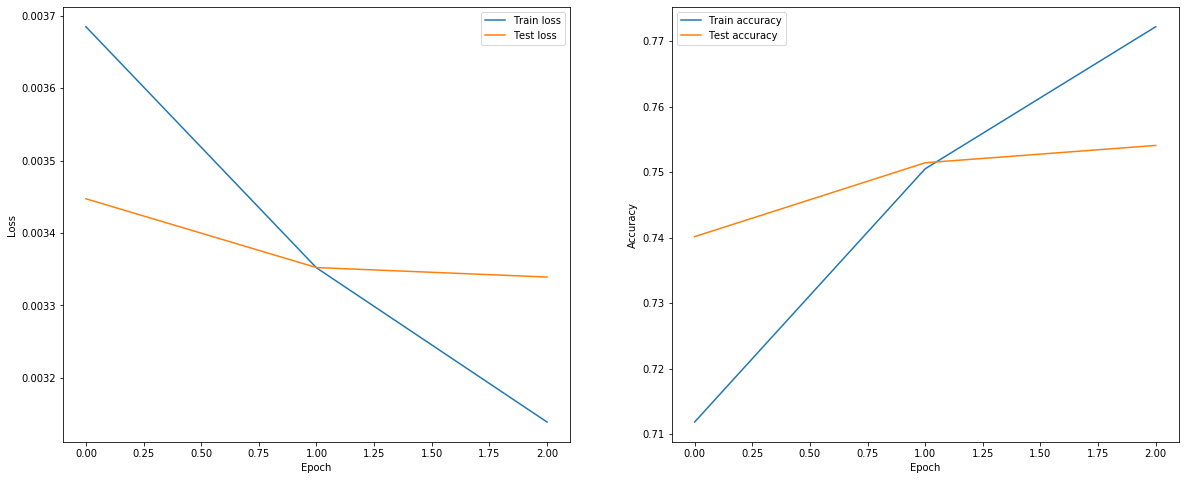

  0%|          | 0/5054 [00:00<?, ?it/s]

Train loss 0.00314, Test loss: 0.00334
Train accuracy  0.772, Test accuracy:  0.754


 82%|████████▏ | 4150/5054 [02:51<00:35, 25.24it/s]

In [ ]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
print(device)

batch_size = 150

model = Bi_LSTM(weights_matrix, 300, batch_size, device).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0)

train_loader = dataLoader(train_tokens, y_train.values, vocab)
val_loader = dataLoader(val_tokens, y_valid.values, vocab)

training(model, optimizer, criterion, train_loader, val_loader, batch_size=batch_size, num_epochs=25, device=device)